# Análise da remuneração líquida média mensal no Executivo civil federal ativo
### A República - Etapa 2

#### Autor: Matheus Cavalcanti Pestana (matheus.pestana@iesp.uerj.br)
#### Linguagem: R

<br>

A presente etapa exige a análise de uma ou duas tendências da remuneração líquida média mensal no Executivo civil federal ativo, por sexo e/ou raça, entre 1999 e 2020. Tais dados podem ser encontrados [aqui](https://www.ipea.gov.br/atlasestado/arquivos/downloads/5233-liquidosexoraca.csv).

A análise se dará em três partes, a saber: *setup* inicial, obtenção e processamento dos dados, e visualizações, que assim permitirão que se disserte sobre os achados. 

Versão R utilizada:

In [ ]:
R.Version()$version.string

[1] "R version 4.1.2 (2021-11-01)"

## 1) Setup inicial

Inicialmente, usaremos quatro pacotes: `tidyverse`, `ggthemes`, `deflateBR` e   `lubridate` . O primeiro é uma *suite* de pacotes que tem como foco a ciência de dados, trabalhando com uma gramática comum que facilita a utilização da linguagem R. O `tidyverse` a torna mais acessível e, por sua vez, mais legível. O segundo pacote traz adicionais para gráficos, tornando-os mais aprazíveis ao leitor e permitindo uma melhor ponte na comunicação dos achados; o terceiro permite que deflacionemos valores a partir de índices, ou seja, como trabalharemos com remuneração, é interessante buscar atualizar esses valores para entender ganhos reais. Já o `lubridate` nos auxiliará a trabalhar com datas.



In [ ]:
# Baixando e instalando os pacotes
install.packages("tidyverse")
install.packages("ggthemes")
install.packages("deflateBR")
install.packages("lubridate")

# Carregando os pacotes no ambiente
library(tidyverse)
library(ggthemes)
library(deflateBR)
library(lubridate)

# Definindo tema de gráficos
theme_set(theme_gdocs())

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.8
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


To cite deflateBR in publications, please use: citation('deflateBR')


Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect,

Com os pacotes instalados e carregados no ambiente do sistema, podemos ir para a segunda parte. 

## 2) Obtenção e processamento dos dados

Como sabido, constando no [documento](https://docs.google.com/document/d/1EiG65bLgXxB2-H1EZ3S00ZGDVolMG4fdrL_gfJu7bZ4/edit), os dados estão no Atlas do Estado Brasileiro, no repositório do IPEA. Uma breve busca nos indica que o *link* para *download* se encontra em https://www.ipea.gov.br/atlasestado/filtros-series/28/vinculos-e-remuneracoes-por-sexo, sendo [esse](https://www.ipea.gov.br/atlasestado/arquivos/downloads/5233-liquidosexoraca.csv) o *link* direto para o arquivo CSV. 

Vamos direcionar o *link*. para um objeto a partir da função `read.csv2`, que lê arquivos CSV separados por ";", diferente da função `read.csv`, que assume que o separador é "," .
Assim, direcionamos ao objeto `df` a função `read.csv2` contendo o link para que o mesmo baixe diretamente os dados e já o converta em um *dataframe* para que possamos analisá-lo. 

In [ ]:
dados <- read.csv2("https://www.ipea.gov.br/atlasestado/arquivos/downloads/5233-liquidosexoraca.csv", row.names = "X") 
# Como geralmente arquivos .csv possuem uma coluna exportada com o índice da linha, adicionamos o argumento row.names = "X" para evitar
# que a mesma seja importada como uma variável/coluna. 

# Olhando como os dados se organizam, entre colunas e linhas
glimpse(dados)

# Fazendo uma breve descrição estatística de cada uma das variáveis
summary(dados)


Rows: 88
Columns: 3
$ ano       <int> 1999, 1999, 1999, 1999, 2000, 2000, 2000, 2000, 2001, 2001, …
$ sexo_raça <chr> "Homem Branco", "Homem Negro", "Mulher Branca", "Mulher Negr…
$ liquido   <dbl> 6527.2, 4768.7, 5261.6, 4010.0, 5690.3, 4151.7, 4887.3, 3782…


      ano        sexo_raça            liquido    
 Min.   :1999   Length:88          Min.   :3734  
 1st Qu.:2004   Class :character   1st Qu.:4989  
 Median :2010   Mode  :character   Median :6097  
 Mean   :2010                      Mean   :6246  
 3rd Qu.:2015                      3rd Qu.:7674  
 Max.   :2020                      Max.   :9279  

Como podemos perceber no *output* acima, temos um banco com 88 linhas e 3 colunas, sendo elas: `ano`, `sexo_raça`, `liquido`, que representa a remuneração líquida média mensal. 

Agora, vamos tentar deflacionar o líquido pelo Índice Nacional de Preços ao Consumidor Amplo (IPCA). Poderíamos utilizar o INPC, mas como o INPC tem como foco o impacto na renda de famílias entre 1 e 5 salários mínimos, e a realidade do serviço público é superior a essa, estaríamos enviesando a análise. A correção dos valores será feita pelo pacote `deflateBR`. Mas antes, utilizaremos o pacote `lubridate` para manipular as datas encontradas.

In [ ]:
dados_deflate <- dados |> # Cria um novo objeto para conter o banco + a variável nova a ser criada
    mutate(ano_clean = dmy(paste0("31/12/", ano)), # Corrige, para que seja utilizado o deflateBR, a variável de data para que de fato seja um tipo "date"
          liquido_deflated = deflate(liquido, ano_clean, "12/1999", "ipca")) # Cria variável com o valor líquido corrigido


...




## 3) Visualizações

Agora, através do pacote `ggplot2` iremos desenvolver algumas visualizações e em seguida, analisá-las, buscando observar tendências possíveis no serviço público brasileiro, no que tange às remunerações.

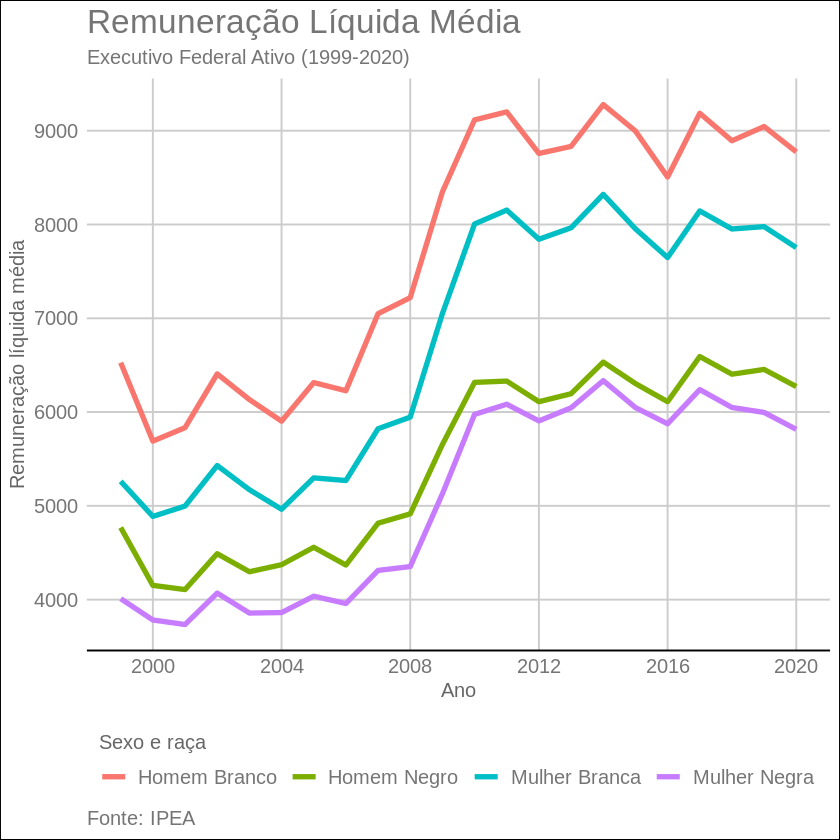

In [ ]:
dados_deflate |> 
  ggplot(aes(x = ano, y = liquido, color = sexo_raça))+ # Define as dimensões de cada eixo
  geom_line(size = 1.5)+ # Cria um geoma de linha
  theme(legend.position = "bottom")+ # Posiciona a legenda abaixo do gráfico
  scale_x_continuous(breaks = seq(2e3, 2020, 4))+ # Aumenta o número de breaks nos eixos
  scale_y_continuous(breaks = seq(1e3, 1e4, 1e3))+
  labs(x = "Ano", y = "Remuneração líquida média", # Define os rótulos
      title = "Remuneração Líquida Média",
      subtitle = "Executivo Federal Ativo (1999-2020)",
      caption = "Fonte: IPEA",
      color = "Sexo e raça")+
  guides(color = guide_legend(ncol = 4)) # Coloca 4 colunas na legenda para aumentar o espaço do gráfico

**INTERPRETAÇÃO:**

Observamos acima 4 curvas que mostram a remuneração líquida média entre 1999 e 2020. Cada curva representa um sexo e raça, sendo homem branco, homem negro, mulher branca e mulher negra. Dado que os reajustes do serviço público são gerais, as curvas se assemelham na variação: se há um aumento de 2% para o funcionalismo público, por exemplo, esse aumento é geral. Todavia, é bastante claro que as curvas se diferenciam na sua altura: homens brancos ganham mais do que mulheres brancas, que por sua vez possuem uma média salarial superior a de homens negros, que estão pouco acima de mulheres negras. **Se o reajuste é pra todos e o acesso é universal, por qual motivo as curvas se distanciam?**

Primeiramente, pensando em termos de gênero, é possível observar que mulheres, apesar de serem maioria no serviço público, recebem menos do que homens e ocupam menos cargos com altos salários, conforme visto em https://republica.org/maioria-no-servico-publico-mulheres-sao-minoria-entre-os-salarios-mais-altos/.

Os motivos são muitos, dentre eles: as profissões de cuidado, como as da área da saúde, são majoritariamente ocupadas por mulheres e por sua vez possuem menor salário, empurrando a média para baixo. Outro fator observado na reportagem é de que quanto maior o nível de confiança do cargo, menor a proporção de mulheres encontrada nele, e isso se dá por uma desigualdade estrutural de gênero entranhada na sociedade brasileira e, por sua vez, em sua burocracia. 

No que tange à raça, percebemos que a diferença entre negros e brancos é grande: brancos possuem os maiores salários, enquanto negros, os menores. Os motivos são similares ao anterior: o acesso aos cargos é dificultado. Em pesquisa do CNJ de 2021 (https://www.cnj.jus.br/wp-content/uploads/2021/09/rela-negros-negras-no-poder-judiciario-150921.pdf), intitulada "Negros e Negras no Judiciário", é perceptível que dentro da esfera judiciária, os negros são minoria. O Judiciário é a área com os maiores salários do funcionalismo público, e apesar de serem maioria na sociedade brasileira, são minoria nos cargos. No caso da Magistratura, dos 62% juízes respondentes da pesquisa do CNJ, apenas 18% eram pretos ou pardos, o que representou um avanço comparado aos anos anteriores. Contudo, o aumento pode se dever a viés amostral e pelo aumento de mais pessoas se declarando pretos e/ou pardos. Ainda assim, são a minoria. 

Conforme pesquisa d'A República.org em parceria com Arapyaú, Humanize e Fundação Lemann (http://negrosnoservicopublico.com), apesar de serem metade dos servidores públicos, ocupam poucos cargos de prestígio e, por sua vez, sua média salarial é inferior. No caso da carreira diplomática, apenas 5,9% dos servidores são negros e negras, **apesar das tentativas, a partir de políticas de ação afirmativa, de diminuir a desigualdade entre negros e brancos**. 

Percebe-se então que tanto a desigualdade de gênero quanto o racismo são perceptíveis no serviço público, dado que o mesmo é um reflexo da sociedade, e isso começa quando, nas melhores escolas, os alunos são majoritariamente brancos, e os negros são maioria na educação pública, que possui muitas vezes uma estrutura de ensino inferior; isso se reflete na universidade, que apesar das políticas de cotas, ainda privilegiam alunos brancos, como estágios que exigem inglês fluente, algo não percebido na camada negra da população, que possui menos acesso a isso; com a necessidade de trabalhar para auxiliar a vida financeira da família, muitos precisam se dedicar menos aos estudos, considerando que é comum aos "concurseiros" a dedicação de ao menos 8h por dia para estudos de concurso público. 

Assim, a desigualdade salarial "acumulada" se manifesta nos quadros do serviço público, o que obstaculiza a criação de novas poílticas que permitam escoimá-la, dado que se há menos negros e mulheres, há menor representatividade desses mesmos indivíduos, o que diminui a percepção da necessidade de políticas direcionadas. 

Uma outra questão que salta aos olhos é o fato de existirem altos salários no funcionalismo. Algumas carreiras, como a magistratura, ultrapassam o teto, e de fato representam um problema para a gestão do erário. Mas será que, na média, isso ainda é verdade? Será que o problema se encontra no funcionalismo de maneira geral, ou em alguns cargos?

Vamos observar os valores deflacionados pelo IPCA para entender, de forma longitudinal, o poder de compra desses mesmos rendimentos:

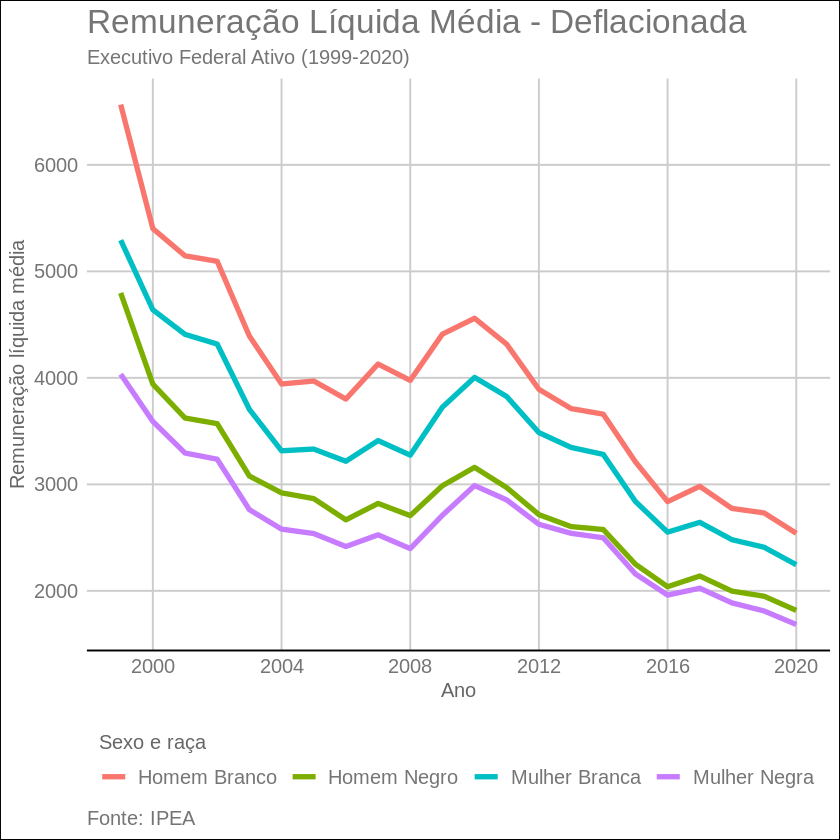

In [ ]:
dados_deflate |> 
  ggplot(aes(x = ano, y = liquido_deflated, color = sexo_raça))+
  geom_line(size = 1.5)+
  theme(legend.position = "bottom")+
  scale_x_continuous(breaks = seq(2e3, 2020, 4))+ 
  scale_y_continuous(breaks = seq(1e3, 8e3, 1e3))+
  labs(x = "Ano", y = "Remuneração líquida média",
      title = "Remuneração Líquida Média - Deflacionada (IPCA)",
      subtitle = "Executivo Federal Ativo (1999-2020)",
      caption = "Fonte: IPEA",
      color = "Sexo e raça")+
  guides(color = guide_legend(ncol = 4))

Apesar dos salários ainda estarem bastante acima da média nacional, considerando o setor privado (o que faz sentido, dada a necessidade de especialização e segurança do setor público), podemos perceber que ao longo do tempo o poder de compra dos salários diminuiu, com um breve aumento entre 2008 e 2012, mas nada comparado ao visto em 1999. 

Segundo pesquisa da Poder360 (https://www.poder360.com.br/governo/com-bolsonaro-uniao-tem-o-menor-numero-de-servidores-ativos-desde-2011/) a União possui pouco mais de meio milhão de servidores ativos. De certa maneira, isso é positivo para auxiliar no equilíbrio das contas públicas e tentar frear o aumento da inflação, mas para a classe, isso representa perdas salariais enormes e é entendido de forma negativa.

Por fim, podemos perceber que muitos são os desafios na gestão pública: a desigualdade racial e de gênero, tanto no acesso quanto na trajetória anterior dos servidores, são fatores marcantes e que saltam aos olhos nas análises anteriores, sendo necessárias políticas que diminuam cada vez mais tais diferenças. A necessidade se representatividade em todos os setores da sociedade, sobretudo no funcionalismo público, é condição necessária para maior democracia no país. 